# Setup
## Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

In [218]:
import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave

# Old df

In [202]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('../Processed dataset/df/image_statistics.csv')
# Dimension 
df.shape

(1794, 13)

In [203]:
# Display the first k rows of a DataFrame
df.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789
1,img01.bmp,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940
2,img01.bmp,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998
3,img01.bmp,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444
4,img01.bmp,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757
5,img01.bmp,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634
6,img01.bmp,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635
7,img01.bmp,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248
8,img01.bmp,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867
9,img01.bmp,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282


## Add part_id and num_voids variables

In [204]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4 + 1
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 2
	elif location == "top_right":
		return (imgid - 1) * 4 + 3
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 4
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))

print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))

1
2
3
5
6
7


In [205]:
def part_id_to_img_info(part_id):
	pid_copy = part_id - 1
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 + 1
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 1:
		location = "top_left"
	elif part_id % 4 == 2:
		location = "bottom_left"
	elif part_id % 4 == 3:
		location = "top_right"
	elif part_id % 4 == 0:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print(part_id_to_img_info(4))

print(part_id_to_img_info(5))
print(part_id_to_img_info(6))

('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')
('02', 'top_left')
('02', 'bottom_left')


In [206]:
# Aggiunta di una nuova colonna 'Part_ID' utilizzando la funzione img_info_to_part_id
df['Part_ID'] = df.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# Aggiunta di una nuova colonna 'Num_voids' utilizzando group by
df['Num_voids'] = df.groupby('Part_ID')['ID'].transform('max')

In [207]:
# Generate summary statistics for the dataframe 'df'
df.describe()

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,21.978818,1121.736901,157.754262,0.810496,0.104399,0.911231,0.552224,31.534230,18.943464,21.709660,20.481048,43.957637
std,13.040740,5670.111640,599.076427,0.199124,0.993198,0.051993,0.111112,38.249285,39.327878,30.942924,11.555677,2.203124
min,0.000000,1.000000,0.000000,0.000000,-1.571000,0.636000,0.125000,0.000000,0.000000,1.128000,1.000000,40.000000
25%,11.000000,126.250000,50.644750,0.765250,-0.999250,0.894000,0.500000,21.029500,8.052500,12.678500,11.000000,42.000000
50%,22.000000,280.500000,76.770000,0.881000,0.231500,0.927000,0.559000,26.724000,13.548000,18.898000,20.000000,44.000000
75%,33.000000,387.000000,85.386500,0.938000,0.937000,0.943000,0.607000,32.384750,19.502250,22.198000,31.000000,46.000000
max,47.000000,40223.000000,4388.970000,1.000000,1.571000,1.000000,1.000000,280.002000,278.184000,226.304000,40.000000,47.000000


In [209]:
# ho to select numeric variables only
dataNum = df.select_dtypes(include=np.number)
dataNum.head(10)

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,1,41
1,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940,1,41
2,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998,1,41
3,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444,1,41
4,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757,1,41
5,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634,1,41
6,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635,1,41
7,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248,1,41
8,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867,1,41
9,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282,1,41


## Df split into parts and voids

In [210]:
# Creazione di df_parts selezionando le righe con "Region type" pari a "part"
df_parts = df[df['Region type'] == 'part']
# Creazione di df_voids selezionando le righe con "Region type" pari a "void"
df_voids = df[df['Region type'] == 'void']

In [17]:
df_parts.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,1,41
42,img01.bmp,bottom_left,part,0,38974,4087.348,0.148,-1.234,0.767,0.721,278.216,275.169,222.763,2,42
85,img01.bmp,top_right,part,0,39176,3988.051,0.163,1.528,0.780,0.712,275.773,272.072,223.339,3,46
132,img01.bmp,bottom_right,part,0,38904,4011.739,0.161,-1.186,0.772,0.670,276.860,273.250,222.563,4,47
180,img02.bmp,top_left,part,0,38376,4133.306,0.119,-0.789,0.755,0.707,278.803,276.832,221.047,5,42
223,img02.bmp,bottom_left,part,0,38086,4233.674,0.104,-0.863,0.750,0.729,279.073,277.567,220.210,6,42
266,img02.bmp,top_right,part,0,37905,4290.058,0.052,-0.869,0.752,0.723,277.310,276.929,219.686,7,47
314,img02.bmp,bottom_right,part,0,38740,4084.335,0.128,-0.828,0.764,0.720,277.947,275.666,222.093,8,44
359,img03.bmp,top_left,part,0,39202,4034.821,0.125,-1.325,0.774,0.722,276.453,274.286,223.413,9,43
403,img03.bmp,bottom_left,part,0,39079,4049.892,0.135,-1.164,0.771,0.714,277.074,274.527,223.063,10,43


# New df
Where new is because we precisely rotate and crop all the images to bring them into a common base on which then compute the variables.\
So we define here df_new and consequently df_new_parts, df_new_voids.
So that the old df and df_ecc remain for comparison.

## Images reorientation and cut

In [254]:
cartella_immagini = {
	'originals': '../Processed dataset/df/',
	'rot&crop': '../Processed dataset/df new/',
	# Altre associazioni possibili
}

def genera_percorso_immagine(part_id, which_ones="originals",option="segmented"):	
	imgnum, location = part_id_to_img_info(part_id)
	nome_immagine = f"img{imgnum}.bmp_{location}_{option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(5, "originals"))
print(genera_percorso_immagine(6, "originals"))

../Processed dataset/df/img01.bmp_top_left_segmented.png
../Processed dataset/df/img01.bmp_bottom_left_segmented.png
../Processed dataset/df/img02.bmp_top_left_segmented.png
../Processed dataset/df/img02.bmp_bottom_left_segmented.png


## START - NOT EXECUTE =========

## Trying to use df angle (unsuccessful)

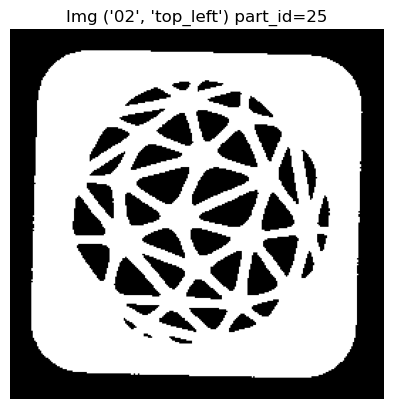

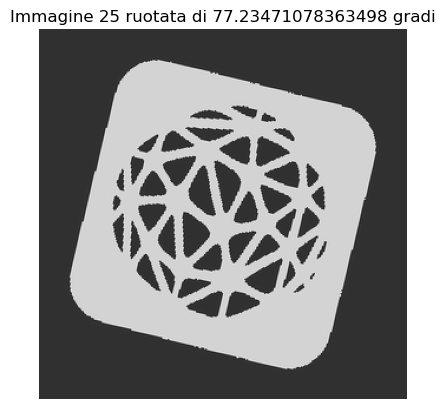

In [213]:
part_id = random.randint(1, 40)

img = plt.imread(genera_percorso_immagine(part_id, "originals"))
plt.imshow(img, cmap='gray')
plt.title(f"Img {part_id_to_img_info(5)} part_id={part_id}")
plt.axis('off')
plt.show()
# it doesnt seem to work this rotation
angolo = math.degrees(df.loc[part_id, 'Orientation [radians]'])
img_ruotata = ndimage.rotate(img, angolo)
plt.imshow(img_ruotata, cmap='gray')
plt.title(f'Immagine {part_id} ruotata di {angolo} gradi')
plt.axis('off')
plt.show()

## Real code for rotate&crop

In [215]:
def rotate_and_crop(img, rect, verbose=0):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	
	if angle > 45:
		angle = angle - 90
	if verbose == 1:
		print(f"Angle inside function is {angle}")
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)

	return img_crop, img_rot

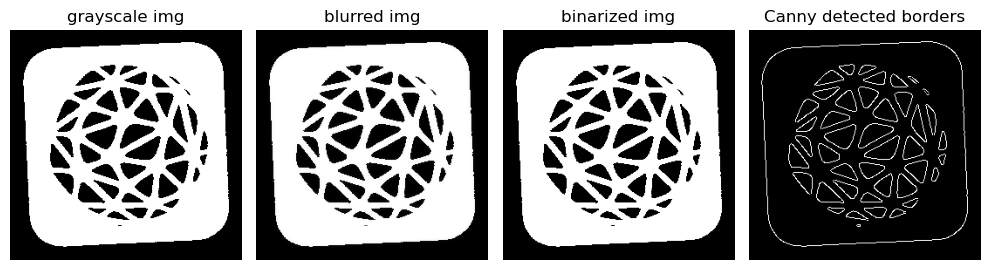

Angle here is 87.33700561523438
Angle inside function is -2.662994384765625
Angle in df was 0.195 radians, ie 11.172677005051053 degrees


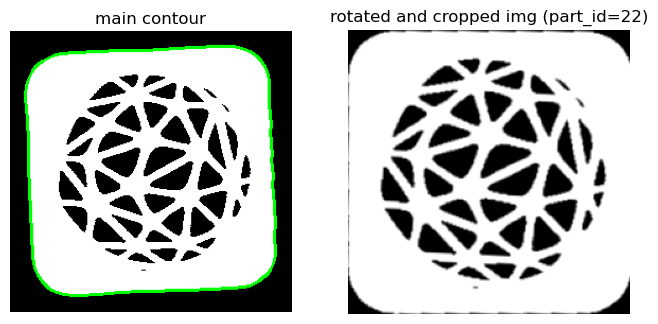

In [217]:
# example about how it works
part_id = random.randint(1,40)
img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(gray, cmap='gray')
plt.title('grayscale img')
plt.axis('off')

# Applica il filtro bilaterale per ridurre il rumore
blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
plt.subplot(1, 4, 2)
plt.imshow(blurred_img, cmap='gray')
plt.title('blurred img')
plt.axis('off')
# maybe blurred not really needed
# decide it in the img input to the next function (choose gray or blurred_img)

# Applica la binarizzazione Otsu
(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.subplot(1, 4, 3)
plt.imshow(threshInv, cmap='gray')
plt.title('binarized img')
plt.axis('off')

# Apply the Canny filter to detect edges
edged = cv2.Canny(threshInv, 30, 200)
plt.subplot(1, 4, 4)
plt.imshow(edged, cmap='gray')
plt.title('Canny detected borders')
plt.axis('off')
plt.tight_layout()
plt.show()

# Find the contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

# Select the biggest contour
largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

img_with_contours = img.copy()
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
cv2.drawContours(img_with_contours, largest_contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.title('main contour')
plt.axis('off')

# crop the pictures following the biggest contour
for i, contours in enumerate (largest_contours):
	# if i % 2 == 0:
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=1)
		print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		plt.subplot(1, 2, 2)
		plt.imshow(cropped_image)
		plt.title(f"rotated and cropped img (part_id={part_id})")
		plt.axis('off')
		plt.show()

## Saving new df

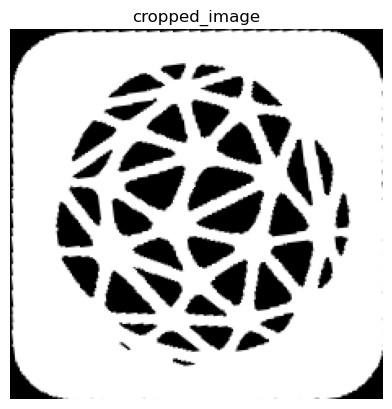

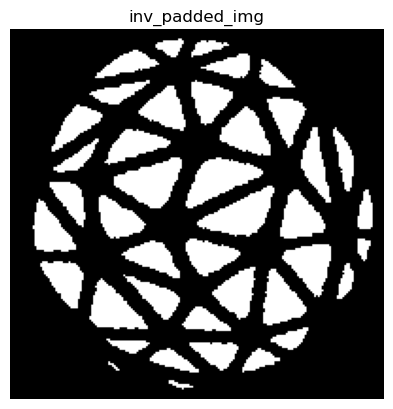

41
41
44
48
41
42
48
43
43
42
45
44
44
42
47
45
43
42
47


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


44


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


41
42
45
39
42
42
46
40
41
42
47
45
42
41
46
41
42
41
47
46


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [190]:
output_folder = "../Processed dataset/df new/"
statistics = []

for part_id in range(1,41):
	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Applica il filtro bilaterale per ridurre il rumore
	blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
	# maybe blurred not really needed
	# decide it in the img input to the next function (choose gray or blurred_img)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)

	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)

		img_info = part_id_to_img_info(part_id)
		filename = f"img{img_info[0]}.bmp_{img_info[1]}_segmented.png"
		cv2.imwrite(os.path.join(output_folder, filename), cropped_image) 

		# print(type(cropped_image))
		if part_id==1:
			plt.imshow(cropped_image)
			plt.axis('off')
			plt.title("cropped_image")
			plt.show()

		# img_pil = Image.fromarray(cropped_image, 'RGB')
		# img_pil = img_pil.convert('L')
		# print(type(img_pil))
		# plt.imshow(img_pil,cmap="gray")
		# plt.axis('off')
		# plt.show()

		gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
		(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
		labeled_segmented_image = label(threshInv)

		# Convert the boolean image to an 8-bit unsigned integer image
		img = (threshInv.astype(np.uint8) * 255)
		# Use regionprops to get properties of the region
		part_props = regionprops(img)[0]  # Get the first (and only) region
		# Crop the image with margin around the bounding box
		minr, minc, maxr, maxc = part_props.bbox
		# print(part_props.bbox)
		minr_crop = max(minr + 15, 0)
		minc_crop = max(minc + 15, 0)
		maxr_crop = min(maxr - 15, img.shape[0])
		maxc_crop = min(maxc - 15, img.shape[1])
		padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]

		# Invert the padded image
		inv_padded_img = 255 - padded_img
		if part_id==1:
			plt.imshow(inv_padded_img,cmap="gray")
			plt.axis('off')
			plt.title("inv_padded_img")
			plt.show()

		# Apply labeling
		labels = label(inv_padded_img, background=0)
		props_voids = regionprops(labels)
		# Find the biggest region
		biggest_region = max(props_voids, key=lambda region: region.area)
		# Set the pixels in the biggest region to 0
		labels[labels == biggest_region.label] = 0
		# Repeat labeling
		labels = label(labels, background=0)
		props_voids = regionprops(labels)
		# Create a figure and axes
		plt.figure(figsize=(8, 8))
		fig, ax = plt.subplots()
		# Display the image
		ax.imshow(labels, cmap='nipy_spectral')
		# Annotate label numbers
		print(len(regionprops(labels)))
		for region in regionprops(labels):
			# Get the coordinates of the centroid
			y, x = region.centroid
			# Annotate the label number at the centroid
			ax.text(x, y, str(region.label), color='white')
		# Save the labeled image  		
		labeled_filename = f"img{img_info[0]}.bmp_{img_info[1]}_labeled.png"
		labeled_output_path = os.path.join(output_folder, labeled_filename)
		plt.savefig(labeled_output_path)
		# Close the figure to free up memory
		plt.close(fig)
		
		# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
		statistics.append({
			"Image name": f"img{img_info[0]}.bmp",
			"Position": img_info[1],
			"Region type": "part",
			"ID": 0,
			"Area [pixels]": round(part_props.area, 3),
			"Perimeter [pixels]": round(part_props.perimeter, 3),
			"Eccentricity": round(part_props.eccentricity, 3),
			"Orientation [radians]": round(part_props.orientation, 3),
			"Solidity": round(part_props.solidity, 3),
			"Extent": round(part_props.extent, 3),
			"Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
			"Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
			"Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3)
		})

		# Loop over each void
		for i, prop in enumerate(props_voids, start=1):
			# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
			statistics.append({
				"Image name": f"img{img_info[0]}.bmp",
				"Position": img_info[1],
				"Region type": "void",
				"ID": i,
				"Area [pixels]": round(prop.area, 3),
				"Perimeter [pixels]": round(prop.perimeter, 3),
				"Eccentricity": round(prop.eccentricity, 3),
				"Orientation [radians]": round(prop.orientation, 3),
				"Solidity": round(prop.solidity, 3),
				"Extent": round(prop.extent, 3),
				"Major Axis Length [pixels]": round(prop.major_axis_length, 3),
				"Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
				"Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3)
			})

# Convert the list of dictionaries to a DataFrame
statistics_df = pd.DataFrame(statistics)
# Export the DataFrame to a CSV file in the output_folder
output_file = os.path.join(output_folder, "image_statistics.csv")
statistics_df.to_csv(output_file, index=False)


## END - NOT EXECUTE =========

# Loading precisely df and new_df
Already available frome the previous code: df, df_parts, df_voids.\
Now here we load df_new, df_new_parts, df_new_voids.

In [195]:
# already loaded, so useless this part actually
df = pd.read_csv('../Processed dataset/df/image_statistics.csv')

df['Part_ID'] = df.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
df['Num_voids'] = df.groupby('Part_ID')['ID'].transform('max')

df_parts = df[df['Region type'] == 'part']
df_voids = df[df['Region type'] == 'void']
df_parts.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,1,41
42,img01.bmp,bottom_left,part,0,38974,4087.348,0.148,-1.234,0.767,0.721,278.216,275.169,222.763,2,42
85,img01.bmp,top_right,part,0,39176,3988.051,0.163,1.528,0.780,0.712,275.773,272.072,223.339,3,46
132,img01.bmp,bottom_right,part,0,38904,4011.739,0.161,-1.186,0.772,0.670,276.860,273.250,222.563,4,47
180,img02.bmp,top_left,part,0,38376,4133.306,0.119,-0.789,0.755,0.707,278.803,276.832,221.047,5,42
223,img02.bmp,bottom_left,part,0,38086,4233.674,0.104,-0.863,0.750,0.729,279.073,277.567,220.210,6,42
266,img02.bmp,top_right,part,0,37905,4290.058,0.052,-0.869,0.752,0.723,277.310,276.929,219.686,7,47
314,img02.bmp,bottom_right,part,0,38740,4084.335,0.128,-0.828,0.764,0.720,277.947,275.666,222.093,8,44
359,img03.bmp,top_left,part,0,39202,4034.821,0.125,-1.325,0.774,0.722,276.453,274.286,223.413,9,43
403,img03.bmp,bottom_left,part,0,39079,4049.892,0.135,-1.164,0.771,0.714,277.074,274.527,223.063,10,43


In [196]:
df_new = pd.read_csv('../Processed dataset/df new/image_statistics.csv')
df_new['Part_ID'] = df_new.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
df_new['Num_voids'] = df_new.groupby('Part_ID')['ID'].transform('max')

df_new_parts = df_new[df_new['Region type'] == 'part']
df_new_voids = df_new[df_new['Region type'] == 'void']
df_new_parts.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,39196,4020.762,0.148,-1.279,0.777,0.761,276.801,273.771,223.396,1,41
42,img01.bmp,bottom_left,part,0,38727,4085.992,0.156,-1.292,0.768,0.752,277.998,274.603,222.056,2,41
84,img01.bmp,top_right,part,0,38915,3932.110,0.186,-1.541,0.780,0.762,276.015,271.213,222.594,3,44
129,img01.bmp,bottom_right,part,0,38849,4035.011,0.157,-1.079,0.773,0.754,276.722,273.296,222.405,4,48
178,img02.bmp,top_left,part,0,37982,4103.850,0.113,-0.777,0.754,0.737,278.170,276.381,219.909,5,41
220,img02.bmp,bottom_left,part,0,37939,4181.691,0.106,-0.660,0.751,0.733,279.056,277.499,219.785,6,42
263,img02.bmp,top_right,part,0,37702,4287.402,0.058,-1.047,0.752,0.735,277.065,276.598,219.097,7,48
312,img02.bmp,bottom_right,part,0,38364,4028.211,0.119,-0.884,0.762,0.745,277.273,275.294,221.013,8,43
356,img03.bmp,top_left,part,0,38882,4029.666,0.131,-1.352,0.773,0.755,276.184,273.800,222.500,9,43
400,img03.bmp,bottom_left,part,0,38817,4027.809,0.113,-0.932,0.770,0.753,276.361,274.599,222.314,10,42


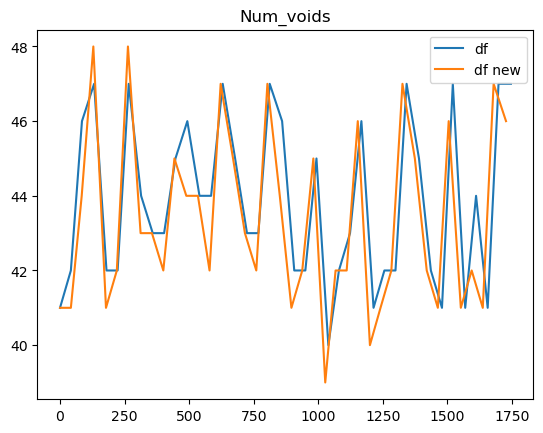

In [200]:
# they are equal almost
plt.plot(df_parts['Num_voids'], label='df')
plt.plot(df_new_parts['Num_voids'], label='df new')
plt.title("Num_voids")
plt.legend()
plt.show()

# Visual exploration

## Comparison of columns in parts data

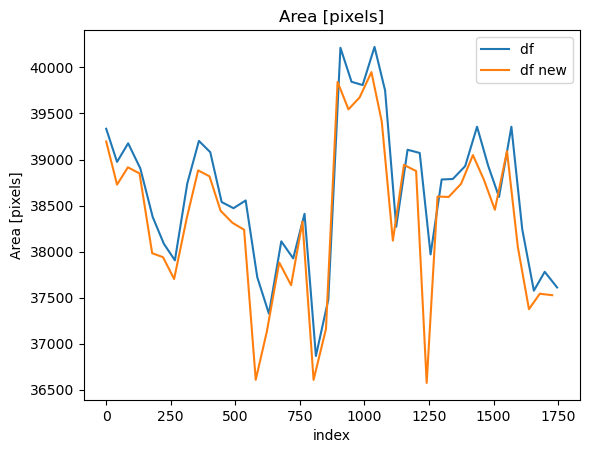

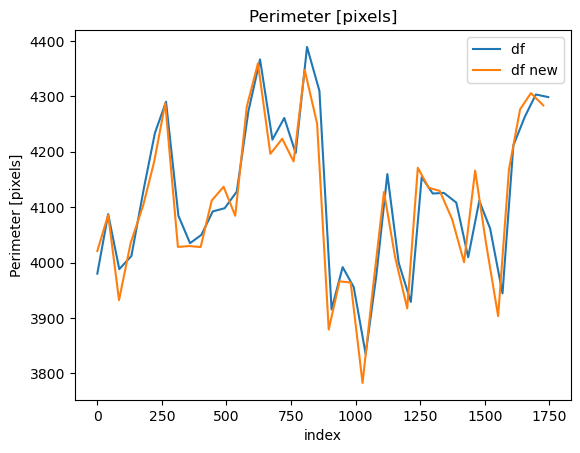

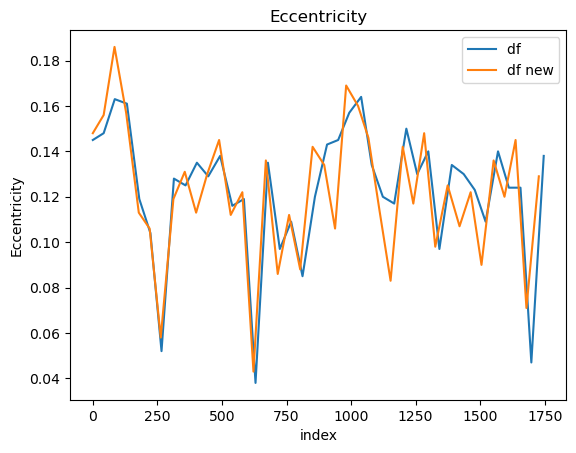

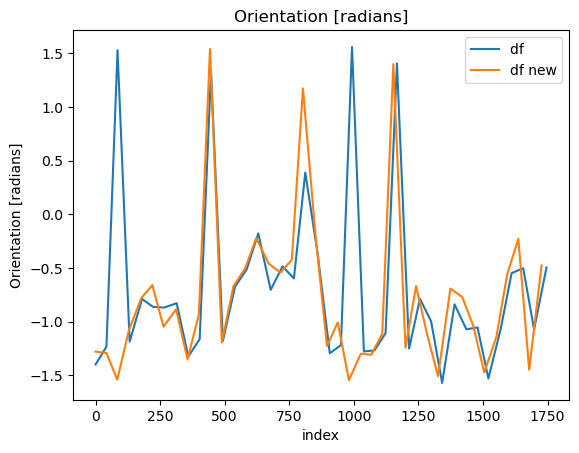

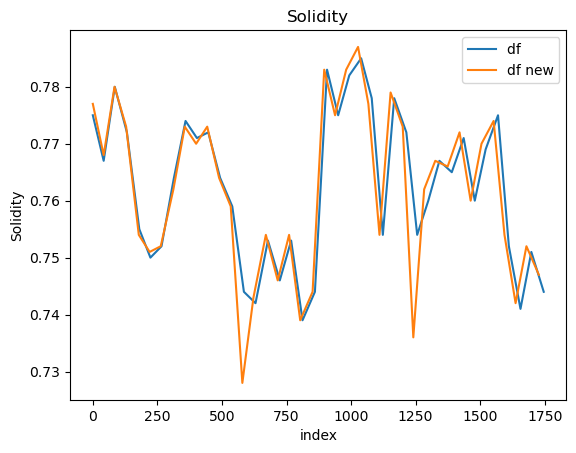

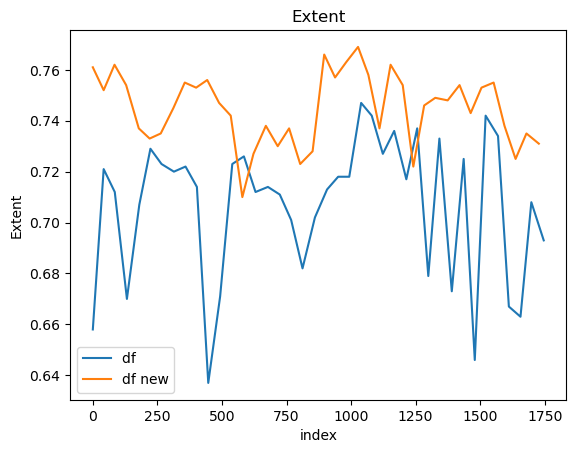

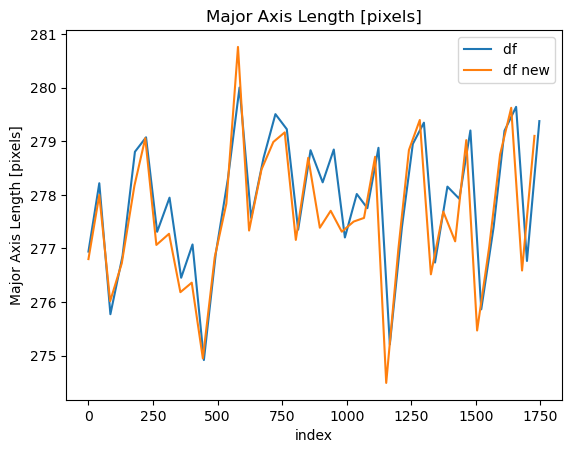

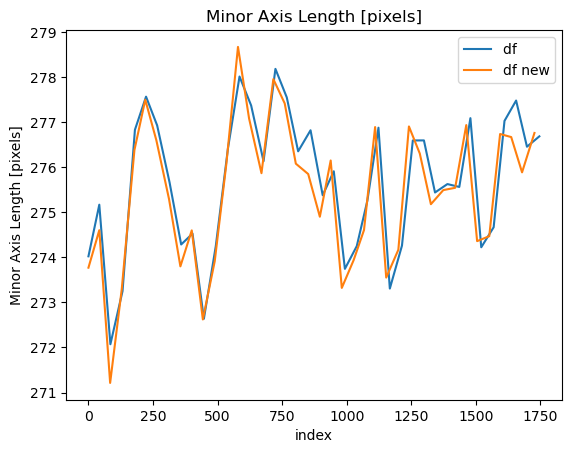

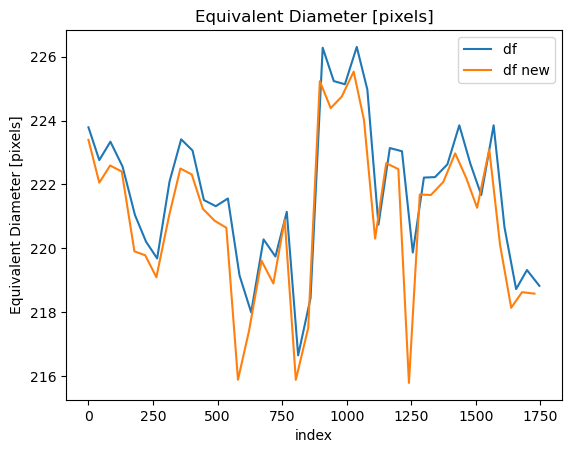

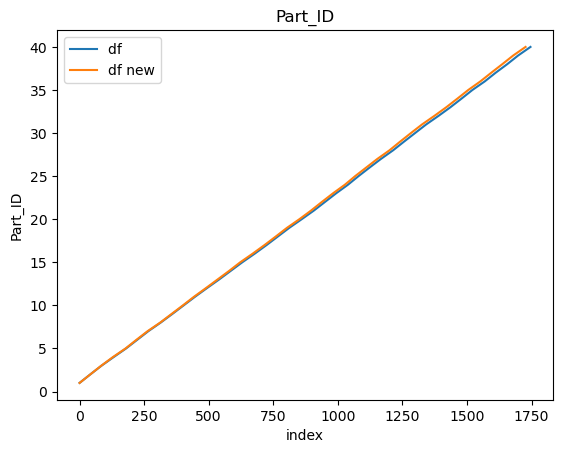

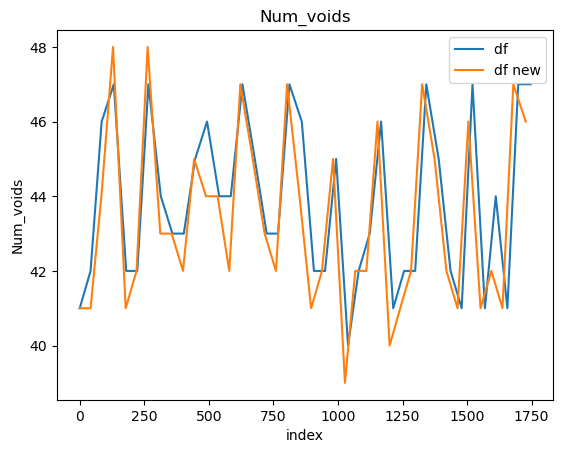

In [226]:
for column in df_parts.columns[4:]:
    # Traccia la colonna corrente di df rispetto alla corrispondente colonna di df_new
    plt.plot(df_parts[column], label='df ')
    plt.plot(df_new_parts[column], label='df new')
    # Aggiungi titolo, etichette degli assi e legenda
    plt.title(column)
    plt.xlabel('index')
    plt.ylabel(column)
    plt.legend()

    # Mostra il grafico per questa coppia di colonne
    plt.show()

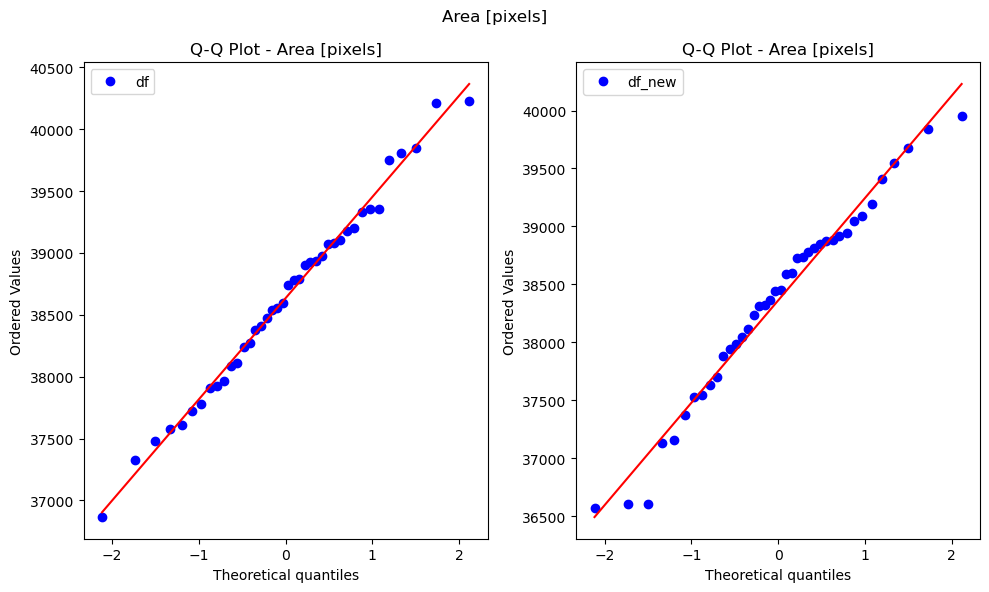

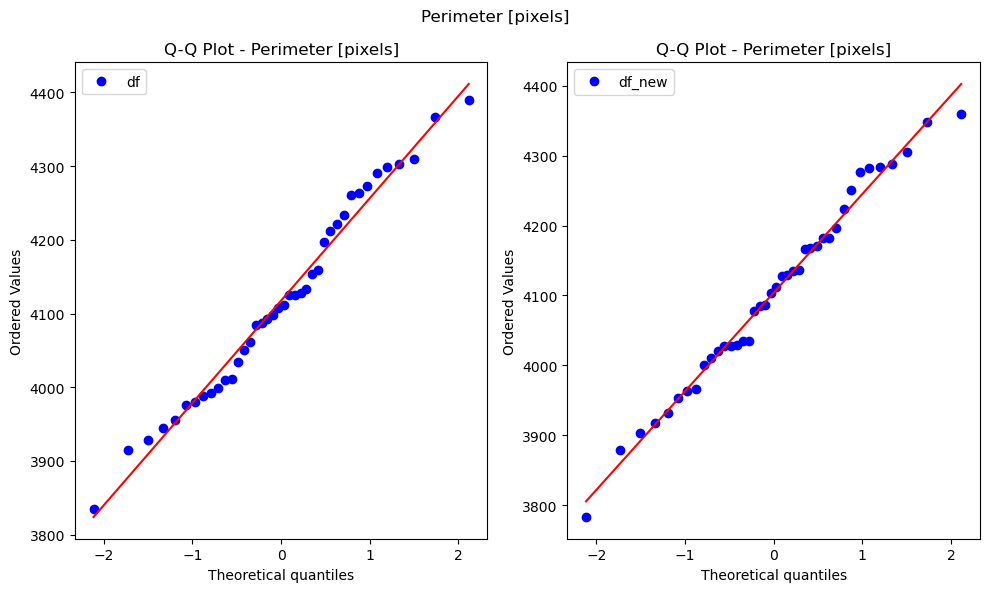

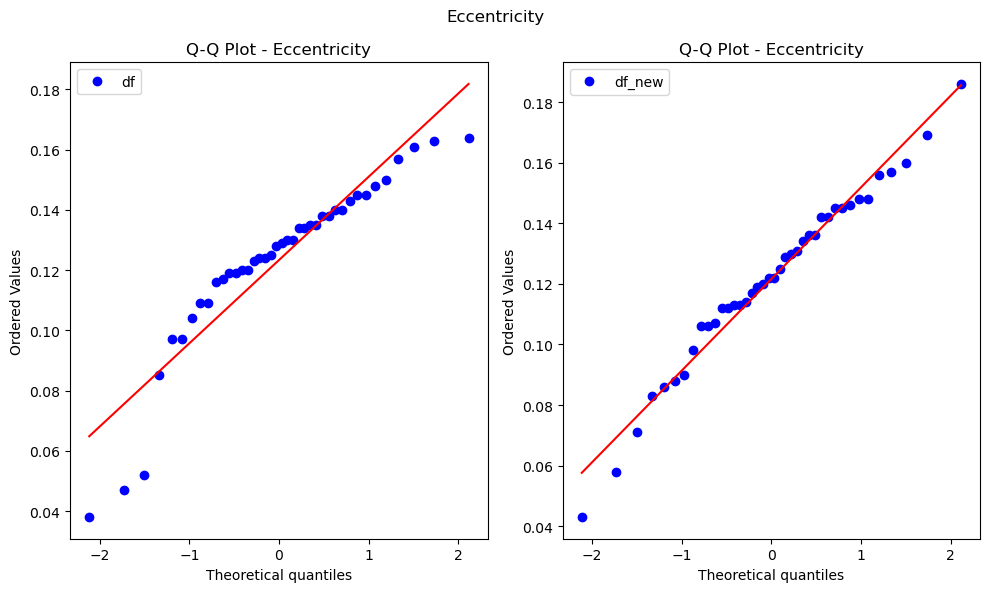

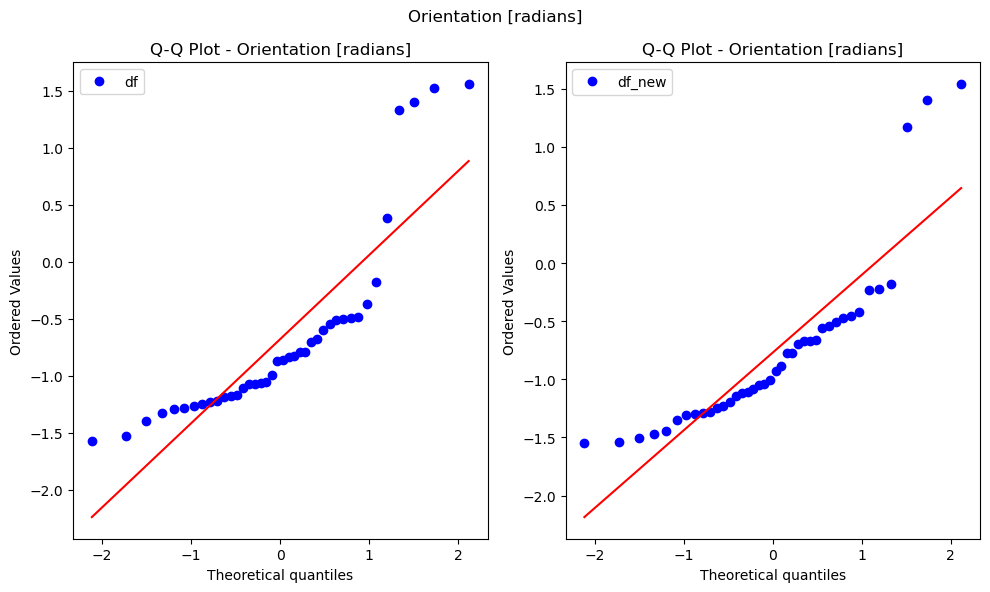

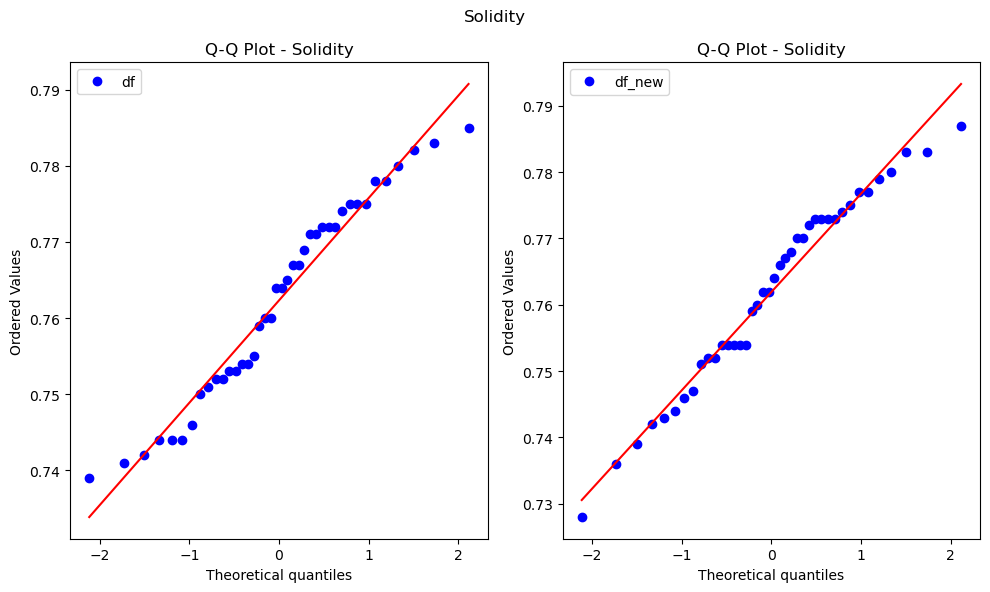

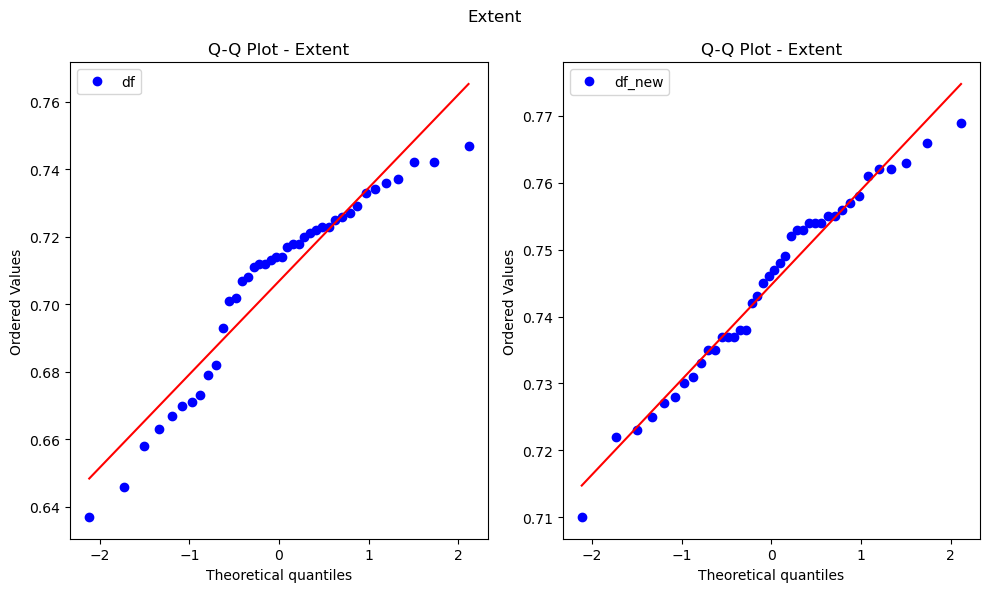

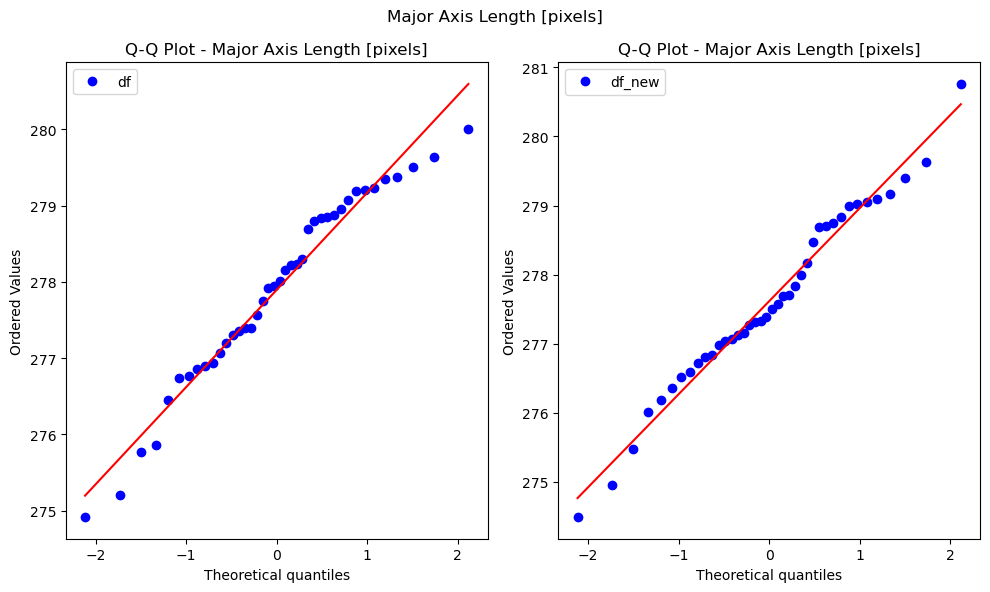

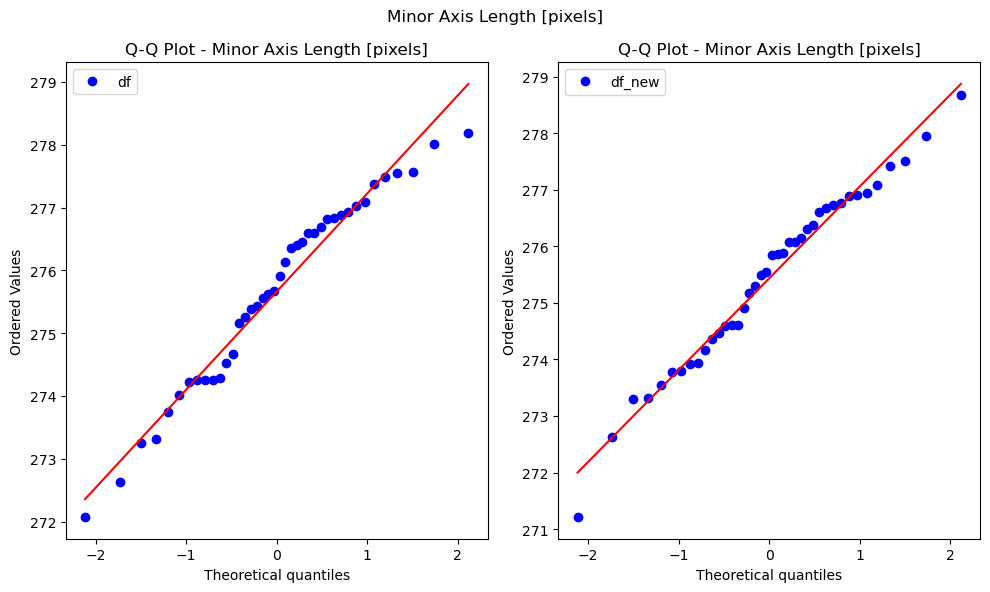

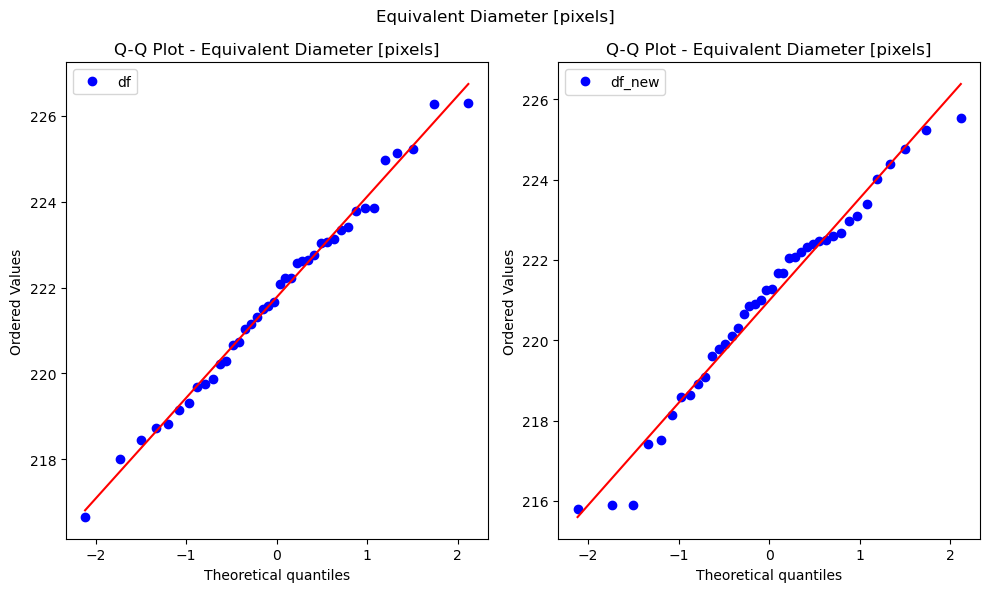

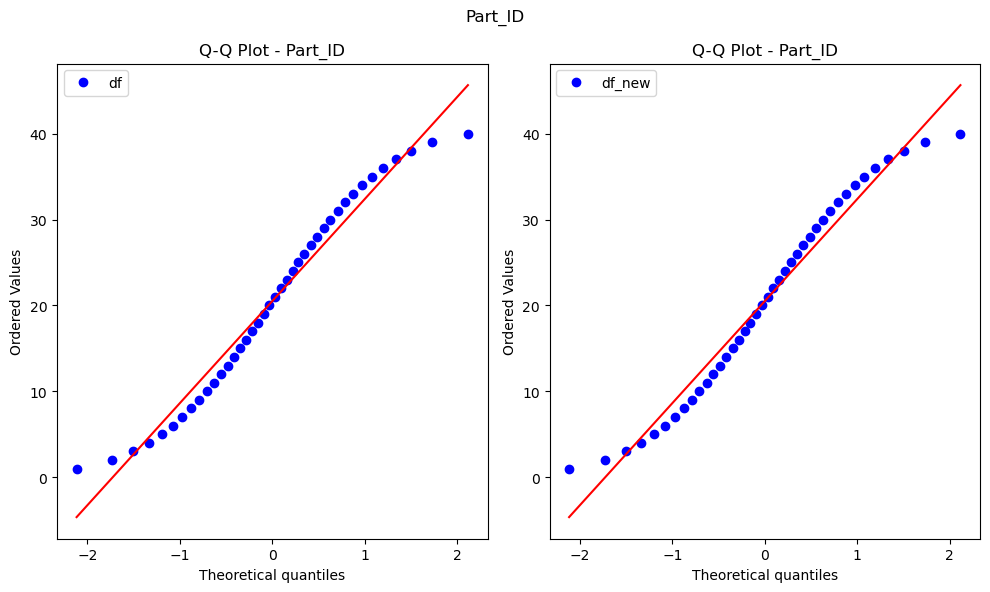

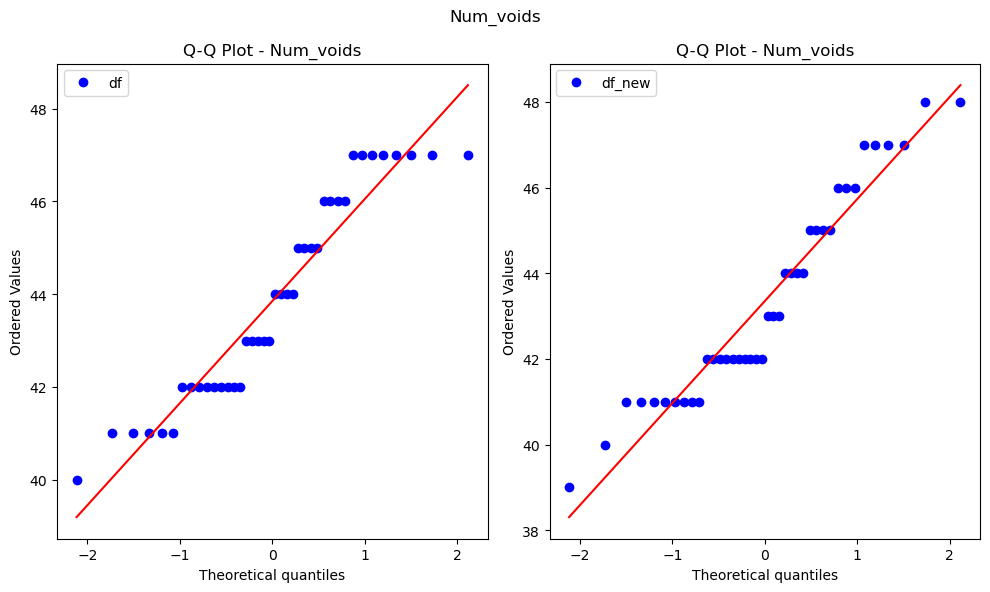

In [245]:
# if we do this plot on df and df_new (rather than df_parts and df_new_parts)
# we clearly see different patterns, so makes sense to divide parts from voids

for i, column in enumerate(df_parts.columns[4:]):
	plt.figure(figsize=(10, 6))
	plt.subplot(1, 2, 1)
	stats.probplot(df_parts[column], dist="norm", plot=plt)
	plt.legend(['df'])
	plt.title(f"Q-Q Plot - {column}")
	# plt.title(f"Q-Q Plot")

	plt.subplot(1, 2, 2)
	stats.probplot(df_new_parts[column], dist="norm", plot=plt)
	plt.legend(['df_new'])
	plt.title(f"Q-Q Plot - {column}")
	# plt.title(f"Q-Q Plot")

	plt.suptitle(column)
	plt.tight_layout()

In [250]:
for column in df_parts.columns[4:]:
    # Calcola il p-value di normalità per la colonna corrente di df_parts
    shapiro_stat, shapiro_pvalue_parts = stats.shapiro(df_parts[column])
    
    # Calcola il p-value di normalità per la colonna corrente di df_new_parts
    shapiro_stat, shapiro_pvalue_new_parts = stats.shapiro(df_new_parts[column])
    
    # Stampa i risultati
    print(f"Colonna: {column}")
    print(f"P-value di normalità per df_parts: {shapiro_pvalue_parts} - normality (alpha 5%)? {shapiro_stat>0.05}")
    print(f"P-value di normalità per df_new_parts: {shapiro_pvalue_new_parts} - normality (alpha 5%)? {shapiro_stat>0.05}\n")

Colonna: Area [pixels]
P-value di normalità per df_parts: 0.9523186683654785 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.421324759721756 - normality (alpha 5%)? True

Colonna: Perimeter [pixels]
P-value di normalità per df_parts: 0.6340415477752686 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.8471523523330688 - normality (alpha 5%)? True

Colonna: Eccentricity
P-value di normalità per df_parts: 0.0004302806337364018 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.729214608669281 - normality (alpha 5%)? True

Colonna: Orientation [radians]
P-value di normalità per df_parts: 1.2606984682861366e-06 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 5.030311058362713e-06 - normality (alpha 5%)? True

Colonna: Solidity
P-value di normalità per df_parts: 0.09568046033382416 - normality (alpha 5%)? True
P-value di normalità per df_new_parts: 0.33506399393081665 - normality (alpha 5%)? True

Colonna: Exte

## View stored images

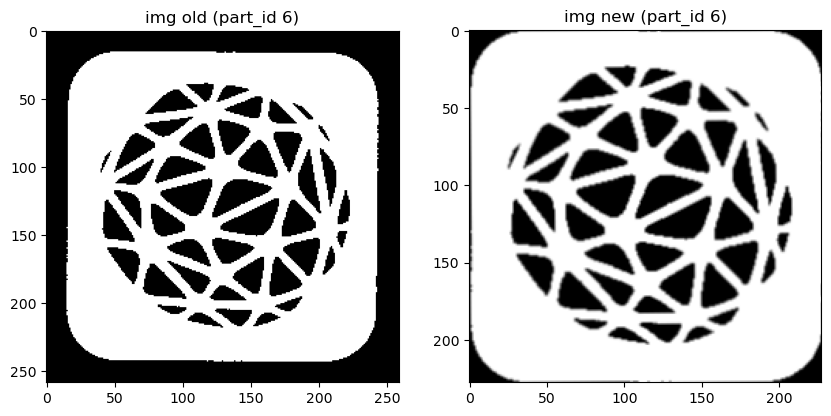

In [261]:
part_id = random.randint(1, 40)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
img_old = plt.imread(genera_percorso_immagine(part_id, "originals"))
plt.imshow(img_old,cmap="gray")
plt.title(f"img old (part_id {part_id})")

plt.subplot(1, 2, 2)
img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop"))
plt.imshow(img_new,cmap="gray")
plt.title(f"img new (part_id {part_id})")
plt.show()

## Old plots

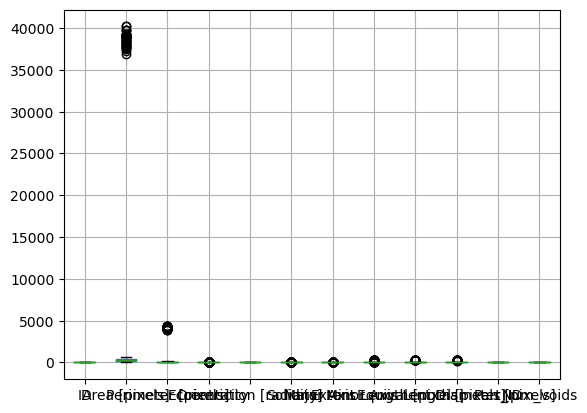

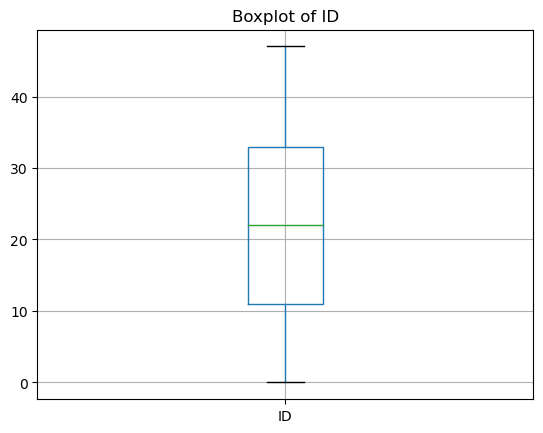

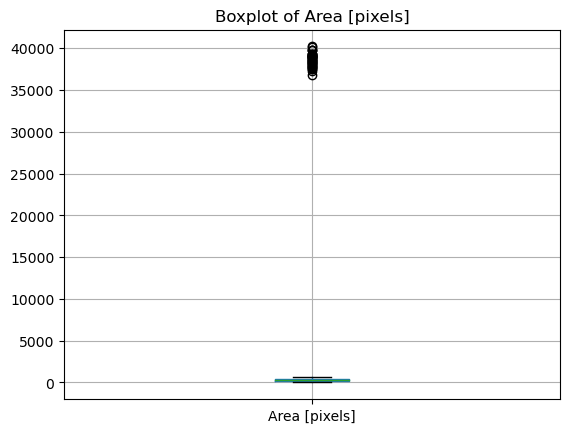

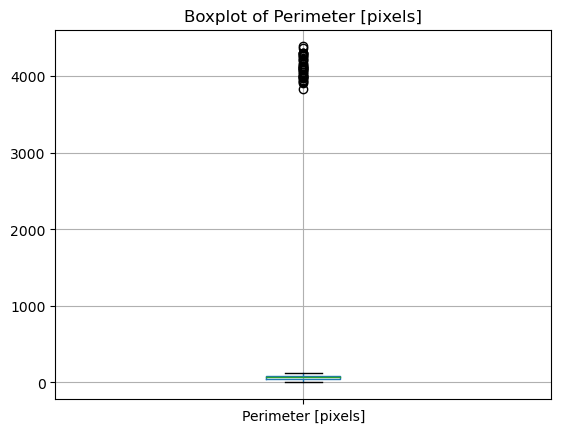

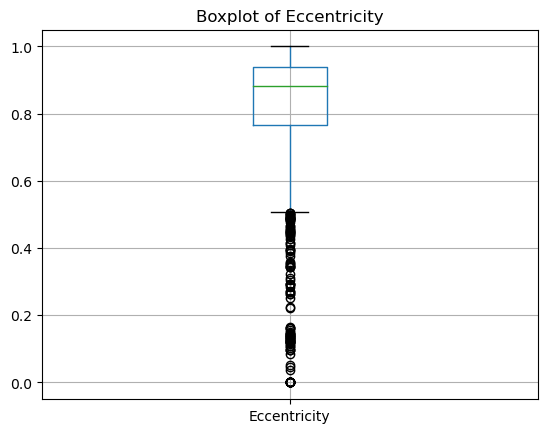

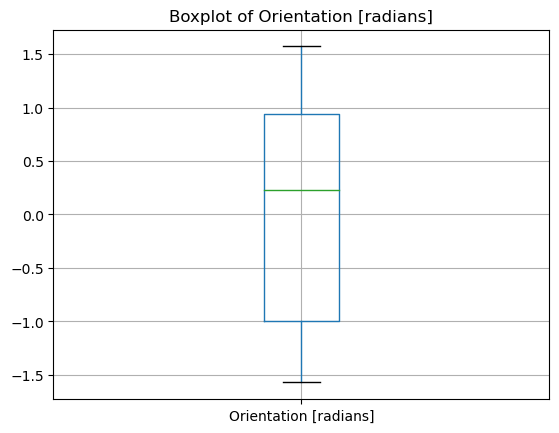

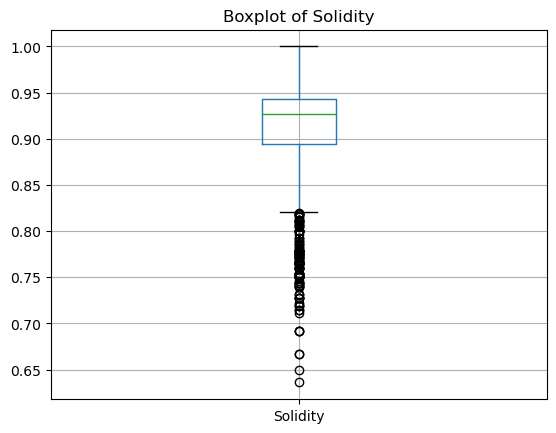

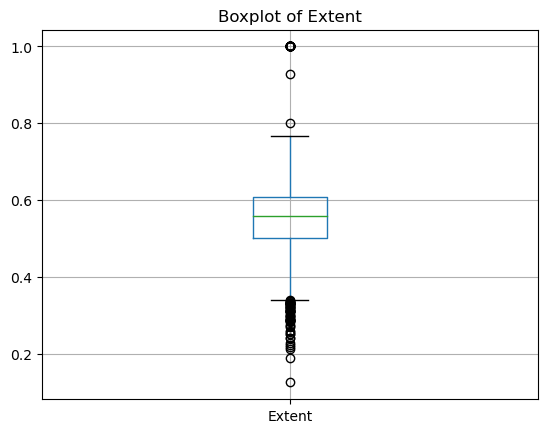

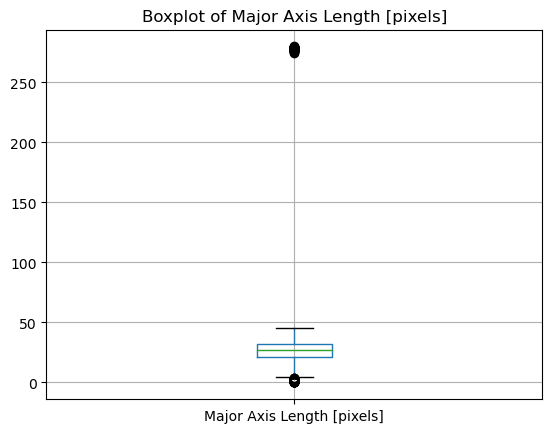

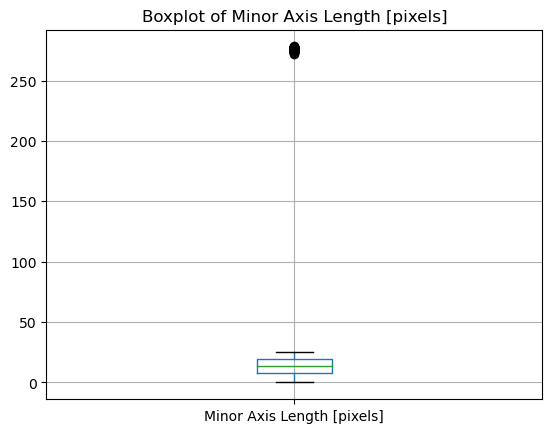

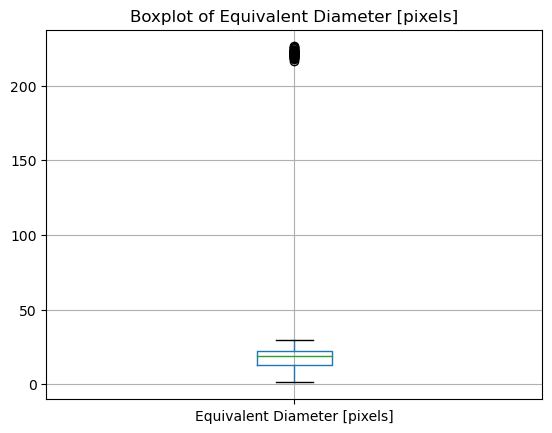

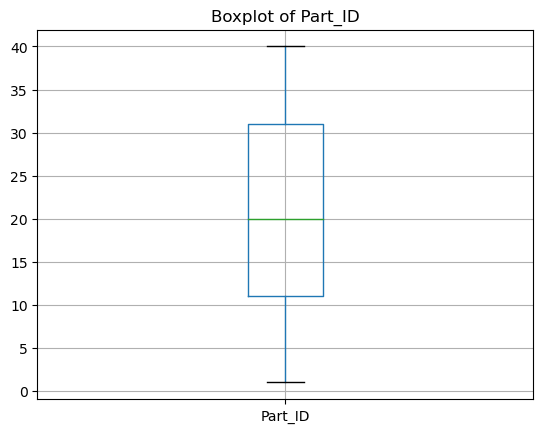

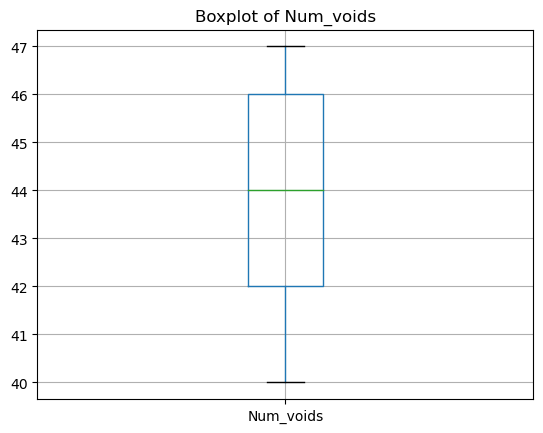

In [31]:
# Boxplot
df.boxplot(dataNum.columns.tolist())
plt.show() 

# Assuming dataNum is your DataFrame containing numerical data
for col in dataNum.columns.tolist():
	dataNum.boxplot(col)
	plt.title(f'Boxplot of {col}')
	plt.show()

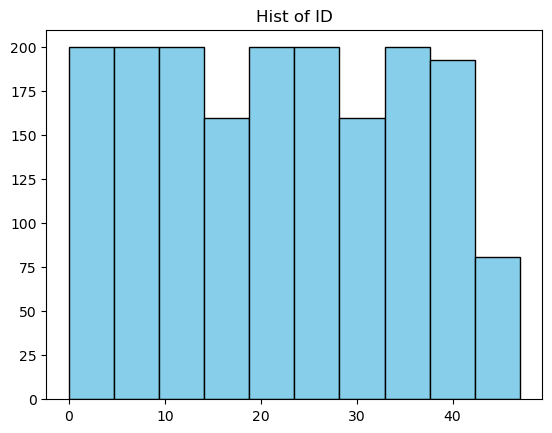

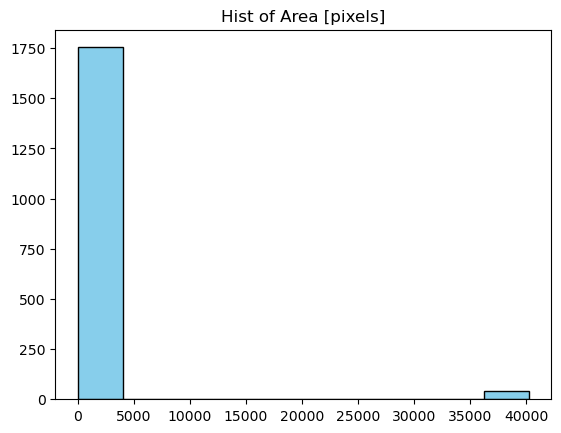

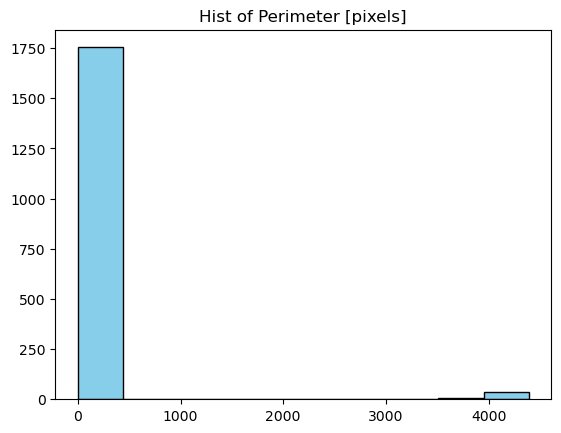

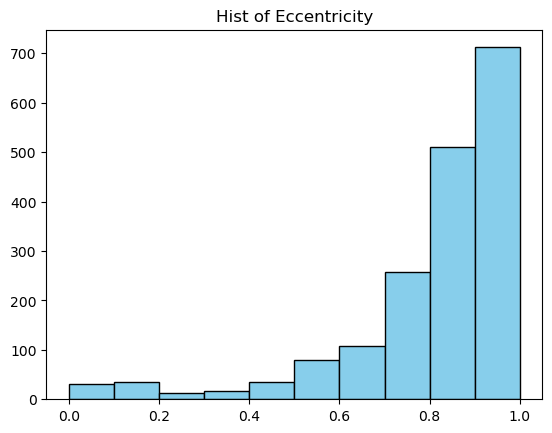

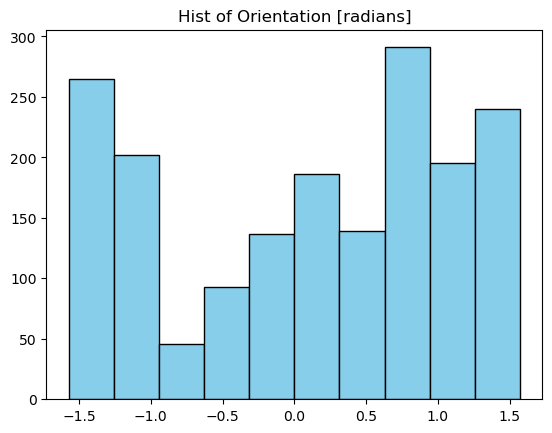

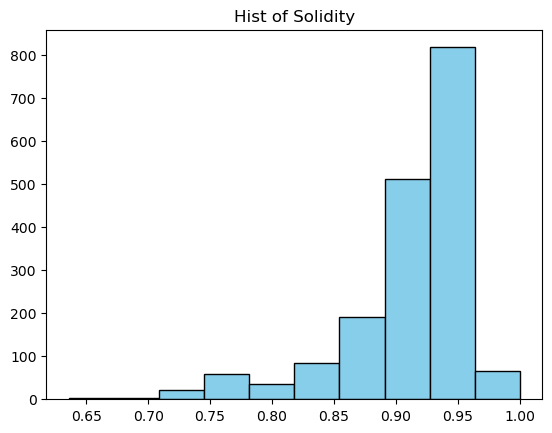

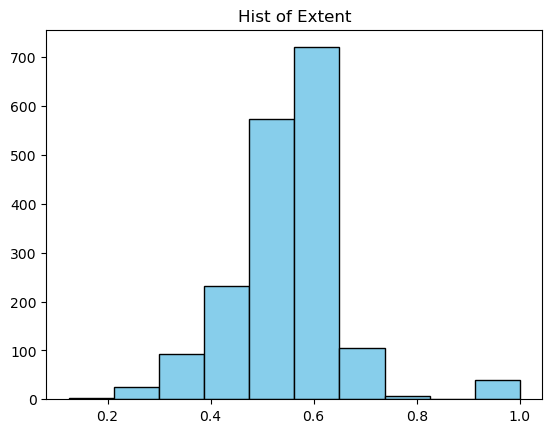

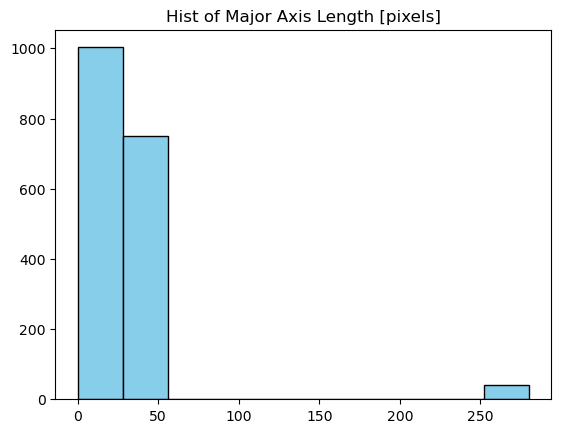

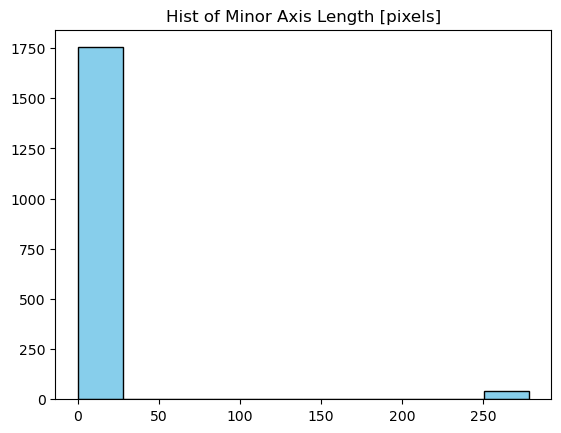

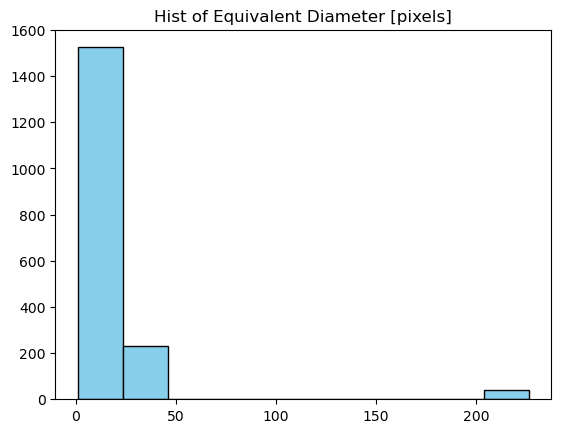

In [71]:
for col in dataNum.columns.tolist():
  plt.hist(dataNum[col], bins=10, color='skyblue', edgecolor='black')
  plt.title(f'Hist of {col}')
  plt.show()


Looking only at the singular images... it seems that the distribution are quite the same

In [85]:
img01_df = df.loc[df['Image name'] == 'img01.bmp', df.columns[3:12]]
img01_df

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels]
0,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023
1,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178
2,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959
3,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699
4,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419
...,...,...,...,...,...,...,...,...,...
175,43,1,0.000,0.000,0.785,1.000,1.000,0.000,0.000
176,44,137,55.698,0.940,1.245,0.907,0.476,23.624,8.073
177,45,1,0.000,0.000,0.785,1.000,1.000,0.000,0.000
178,46,74,37.971,0.933,-1.287,0.881,0.544,16.737,6.026


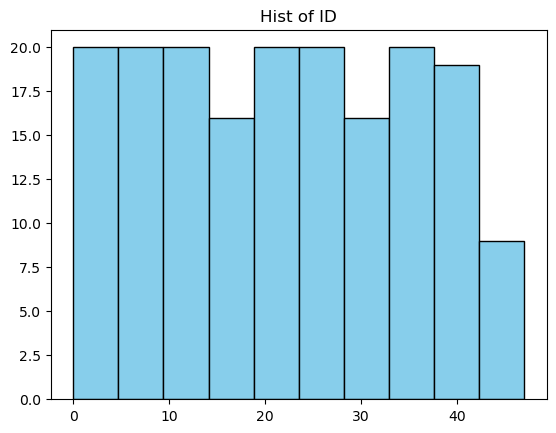

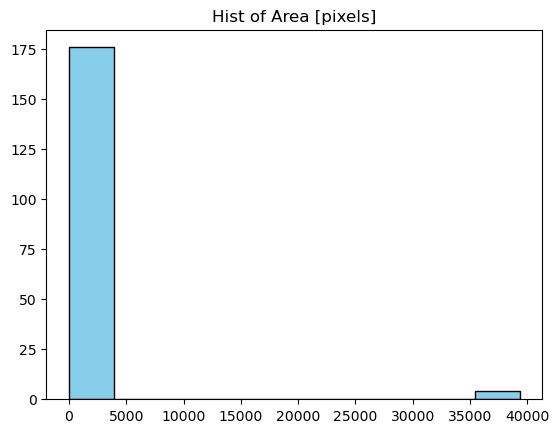

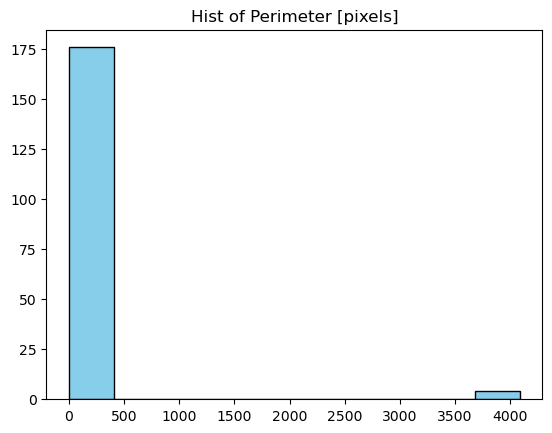

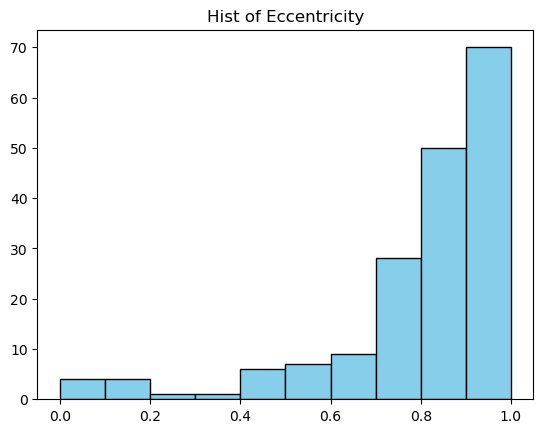

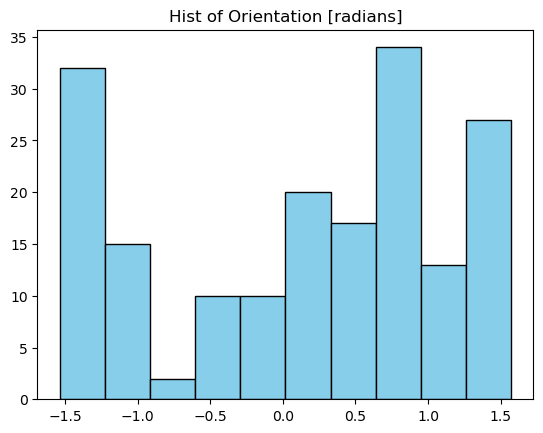

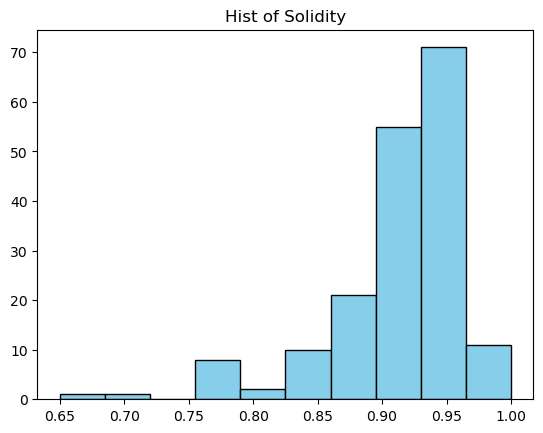

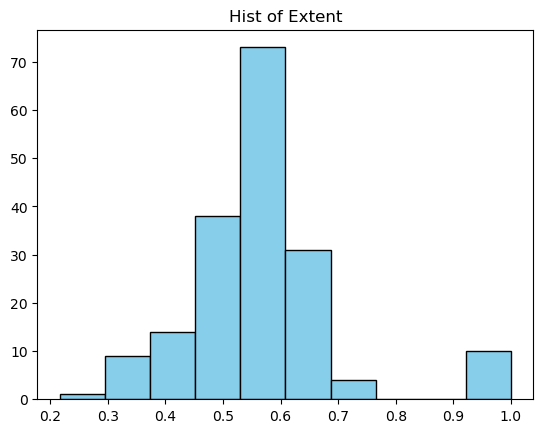

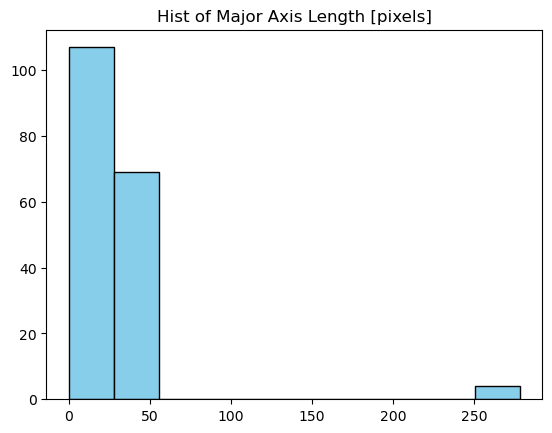

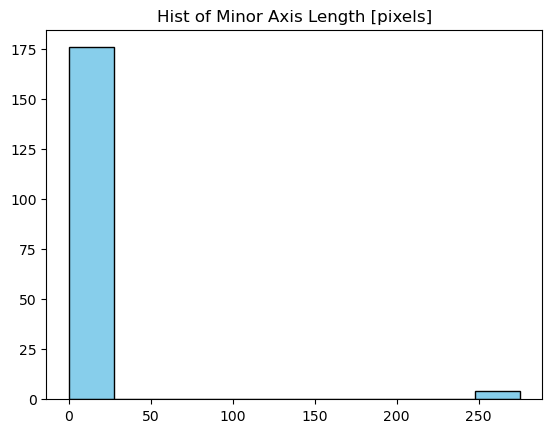

In [83]:
# Seleziona solo le righe con 'Image name' uguale a 'img01.bmp'
img01_df = df.loc[df['Image name'] == 'img01.bmp', df.columns[3:12]]

# Itera sulle colonne di questo sotto-dataframe
for col in img01_df.columns.tolist():
	plt.hist(img01_df[col], bins=10, color='skyblue', edgecolor='black')
	plt.title(f'Hist of {col}')
	plt.show()


Some notes:  
- which is the scope?  
- can we create new variables?  
-  adding image analysis  
- the eccentricity --> log(-eccentricity) ( for normality)  
- remove outliers/ interpret them


## Normality assumption

In [21]:
for col in dataNum.columns.tolist():
  # Shapiro-Wilk test
  _, p_value_SW = stats.shapiro(dataNum[col])
  print('p-value of the Shapiro-Wilk ', col, ' test: %.3f' % p_value_SW)

p-value of the Shapiro-Wilk  ID  test: 0.000
p-value of the Shapiro-Wilk  Area [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Perimeter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Eccentricity  test: 0.000
p-value of the Shapiro-Wilk  Orientation [radians]  test: 0.000
p-value of the Shapiro-Wilk  Solidity  test: 0.000
p-value of the Shapiro-Wilk  Extent  test: 0.000
p-value of the Shapiro-Wilk  Major Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Minor Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Equivalent Diameter [pixels]  test: 0.000


In [ ]:
# QQ-plot
for col in dataNum.columns.tolist():
  stats.probplot(dataNum[col], dist='norm', plot=plt)
  plt.show()

In [27]:
# Anderson-Darling test ???? SOME PROBLEMS

def ADpvalue(data):
	"""
	This function computes the p-value of the Anderson-Darling test.
	
	Input:
		data: data to be tested
	Output:
		p_value_AD: p-value of the Anderson-Darling test
	"""
	anderson = stats.anderson(data, dist='norm')
	# compute the p-value of the Anderson-Darling test
	if anderson.statistic >= 0.6:
		p_value_AD = np.exp(1.2937 - 5.709*anderson.statistic + 0.0186*(anderson.statistic**2))
	elif anderson.statistic >= 0.34:
		p_value_AD = np.exp(0.9177 - 4.279*anderson.statistic - 1.38*(anderson.statistic**2))
	elif anderson.statistic >= 0.2:
		p_value_AD = 1 - np.exp(-8.318 + 42.796*anderson.statistic - 59.938*(anderson.statistic**2))
	else:
		p_value_AD = 1 - np.exp(-13.436 + 101.14*anderson.statistic - 223.73*(anderson.statistic**2))

	return p_value_AD

# Example usage with a DataFrame 'dataNum'
# Assuming 'dataNum' is your DataFrame containing numerical data
# Assuming each column in 'dataNum' represents a variable you want to test

for col in dataNum.columns.tolist():  
	p_value_AD = ADpvalue(dataNum[col])
	print(f'p-value of the Anderson-Darling test for {col}: {p_value_AD:.3f}')


p-value of the Anderson-Darling test for ID: 0.000
p-value of the Anderson-Darling test for Area [pixels]: inf
p-value of the Anderson-Darling test for Perimeter [pixels]: inf
p-value of the Anderson-Darling test for Eccentricity: 0.000
p-value of the Anderson-Darling test for Orientation [radians]: 0.000
p-value of the Anderson-Darling test for Solidity: 0.000
p-value of the Anderson-Darling test for Extent: 0.000
p-value of the Anderson-Darling test for Major Axis Length [pixels]: 1511030393770227162003779399905844333357419357264268208936458972611295710864454567262998905429485439856992987283169820189994024308959741793337201646307926041823825486650119331757704464815929662145550627110912.000
p-value of the Anderson-Darling test for Minor Axis Length [pixels]: inf
p-value of the Anderson-Darling test for Equivalent Diameter [pixels]: 19315448332851835944334324422462959672560793981042361528673147246919530470579697039170133220422593838138142737771726343084849060416283304997276745743537487

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [48]:
min(dataNum['Orientation [radians]'])

-1.571

Since for the scipy.special.boxcox transformation all variables must be positive, I apply a linear transformation to all the dataset --> dataset.pos = datset + pi/2+0.001.  
Rotate pi/2 Cartesian axis ( see slides REGION PROPERTIES - ORIENTATION)

Note that i chose to use this thpe of trasformation becuause the majority of the problem are related to the orientation column, in this way we obtain all positive values.

In [59]:
import math

dataNumTrasf = pd.DataFrame()  # Initialize an empty DataFrame to store transformed data

# Assuming dataNum is your DataFrame containing numerical data
dataNumTrasf = dataNum.iloc[:, 1:] + math.pi/2 + 0.001 # remove ID column

In [58]:
dataNumTrasf.head(100)

,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,39335.571796,3981.463796,1.716796,0.172796,2.346796,2.229796,278.512796,275.594796,225.360796
1,95.571796,39.127796,2.344796,3.016796,2.520796,2.267796,16.034796,10.749796,12.511796
2,96.571796,47.713796,2.506796,0.105796,2.443796,2.136796,21.218796,8.530796,12.569796
3,240.571796,79.098796,2.513796,0.139796,2.480796,2.140796,33.555796,12.270796,19.015796
4,196.571796,62.991796,2.456796,3.116796,2.478796,2.148796,26.106796,12.990796,17.328796
...,...,...,...,...,...,...,...,...,...
95,242.571796,68.648796,2.381796,1.856796,2.484796,2.138796,25.939796,15.863796,19.088796
96,384.571796,82.583796,2.277796,2.347796,2.507796,2.160796,29.174796,21.125796,23.654796
97,356.571796,91.755796,2.483796,0.184796,2.470796,2.104796,37.079796,16.145796,22.831796
98,43.571796,30.920796,2.549796,1.044796,2.335796,1.894796,17.980796,4.993796,8.884796


In [60]:

# Box-Cox transformation

data_norm = pd.DataFrame() 

for col in dataNumTrasf.columns.tolist():
	data_norm[col], lmbda = stats.boxcox(dataNumTrasf[col])
	print(f'Lambda for {col} = {lmbda:.3f}')


Lambda for Area [pixels] = -0.012
Lambda for Perimeter [pixels] = -0.019
Lambda for Eccentricity = 10.371
Lambda for Orientation [radians] = 0.774
Lambda for Solidity = 24.228
Lambda for Extent = -1.098
Lambda for Major Axis Length [pixels] = 0.059
Lambda for Minor Axis Length [pixels] = -0.087
Lambda for Equivalent Diameter [pixels] = -0.095


In [61]:
data_norm.head(10)

,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,9.944978,7.666808,26.110187,-0.960220,3.903302e+07,0.533177,6.684819,4.446268,4.239288
1,4.439151,3.541439,664.375719,1.744540,2.208003e+08,0.540118,3.016493,2.145993,2.247459
2,4.449013,3.726065,1328.443578,-1.065175,1.041326e+08,0.515095,3.349568,1.955975,2.251100
3,5.309089,4.193330,1367.424798,-1.010473,1.498645e+08,0.515907,3.906614,2.253050,2.570642
4,5.119550,3.983407,1077.934313,1.822140,1.469646e+08,0.517520,3.599654,2.298799,2.500018
5,4.849733,3.880213,1068.867624,1.243592,1.543175e+08,0.496396,3.417669,2.192644,2.399607
6,5.105100,4.124578,1436.660822,-1.023044,1.138323e+08,0.507644,3.847009,2.141894,2.494621
7,5.586402,4.136237,73.204877,0.917889,2.165949e+08,0.524046,3.476507,2.724626,2.674075
8,5.642396,4.177573,182.130339,1.304954,1.785531e+08,0.520908,3.562726,2.716640,2.694946
9,5.495477,4.209296,1167.598472,-0.423315,1.785531e+08,0.487559,3.877433,2.407034,2.640173


In [62]:
for col in data_norm.columns.tolist():
  # Shapiro-Wilk test
  _, p_value_SW = stats.shapiro(data_norm[col])
  print('p-value of the Shapiro-Wilk ', col, ' test: %.3f' % p_value_SW)

p-value of the Shapiro-Wilk  Area [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Perimeter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Eccentricity  test: 0.000
p-value of the Shapiro-Wilk  Orientation [radians]  test: 0.000
p-value of the Shapiro-Wilk  Solidity  test: 0.000
p-value of the Shapiro-Wilk  Extent  test: 0.000
p-value of the Shapiro-Wilk  Major Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Minor Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Equivalent Diameter [pixels]  test: 0.000


The box cox trasformation does not solve the pb of guassian distrution -> we can try more values for lambda / outlier analysis

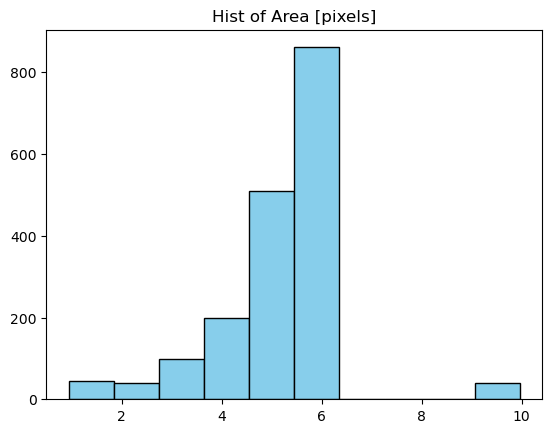

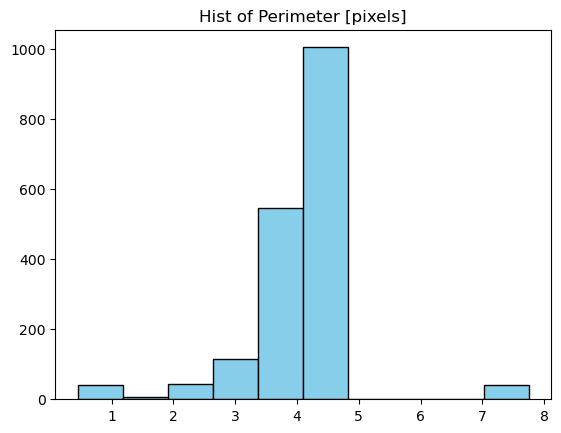

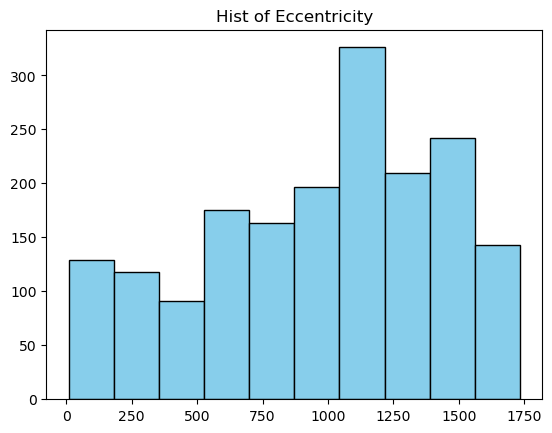

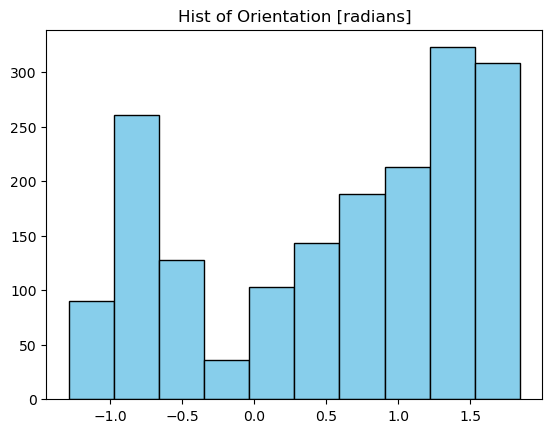

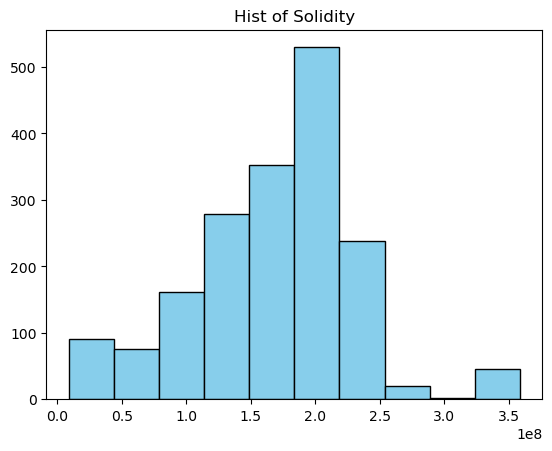

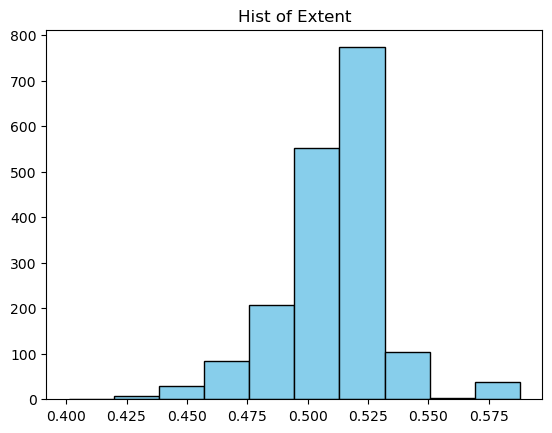

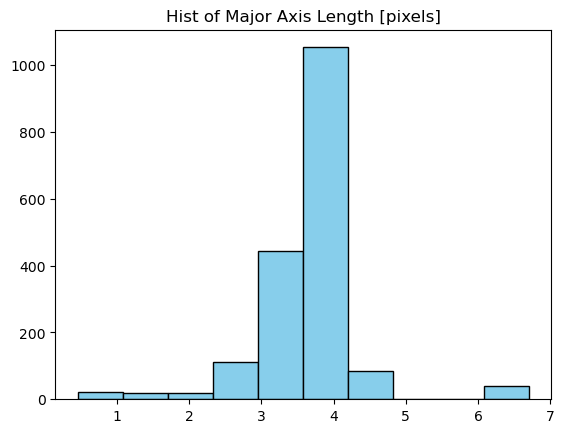

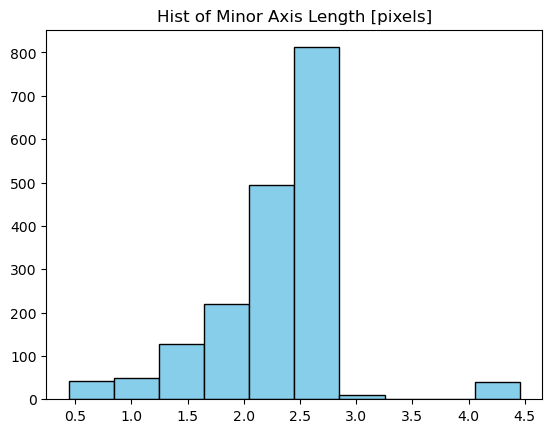

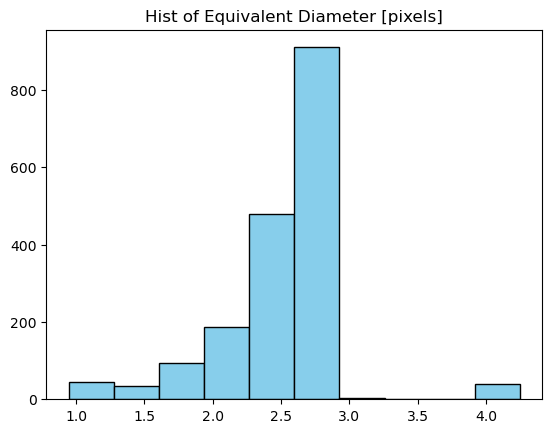

In [66]:
for col in data_norm.columns.tolist():
  # Shapiro-Wilk test
  plt.hist(data_norm[col], bins=10, color='skyblue', edgecolor='black')
  plt.title(f'Hist of {col}')
  plt.show()


